# NLP Project - A.A. 2024/25

Authors:

- Gigante Davide (11018245)
- Puccia Niccolò (10829496)
- Sichili Giulio (11016179)
- Troiano Alessandro (10776474)

Link to the recording: AAAA

# WORKFLOW
Possiamo provare a classificare le subjects (che sono 3, più semplice), o i topics, che sono di più e tendono a sovrapporsi più spesso. Partiamo dalla prima.

PRIMA PARTE
- Carica i dati
- Manteniamo le colonne che ci servono per la classificazione
- Eseguiamo operazioni sui dati che servono per pulire il dataset qualunque modello useremo per la classificazione




# Multimodal Question Answering: ScienceQA

## Connect to Google Drive

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

folder = "/content/drive/My Drive/NLP project"
os.chdir(folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install Dependencies and libraries

In [2]:
!pip install -U datasets
!pip install --upgrade gensim

In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import mode
import re
import string


import nltk
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
import plotly.express as px

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [4]:
ds = load_dataset("derek-thomas/ScienceQA")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

(…)-00000-of-00001-1028f23e353fbe3e.parquet:   0%|          | 0.00/377M [00:00<?, ?B/s]

(…)-00000-of-00001-6c7328ff6c84284c.parquet:   0%|          | 0.00/126M [00:00<?, ?B/s]

(…)-00000-of-00001-f0e719df791966ff.parquet:   0%|          | 0.00/122M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12726 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4241 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4241 [00:00<?, ? examples/s]

In [5]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 12726
    })
    validation: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 4241
    })
    test: Dataset({
        features: ['image', 'question', 'choices', 'answer', 'hint', 'task', 'grade', 'subject', 'topic', 'category', 'skill', 'lecture', 'solution'],
        num_rows: 4241
    })
})

### Suppress Warnings

In [6]:
import warnings
warnings.filterwarnings("ignore")

# 1. Data Preprocessing

### Importing utilities

In [7]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True


### Cleaning utilities
Compiled objects live at module scope for maximum speed.



In [8]:
import re, string
from nltk.corpus import stopwords
from nltk import word_tokenize

# Try simple_preprocess from gensim, because we need the same preprocessing of the Word2Vec model

# Setup
_PUNCT_RE   = re.compile(f"[{re.escape(string.punctuation)}]")
_STOP_WORDS = set(stopwords.words("english"))

def clean_text(text: str) -> list[str]:
    """clean = _PUNCT_RE.sub("", text.lower())
    tokens = [t for t in word_tokenize(clean) if t.isalpha() and t not in _STOP_WORDS]"""
    tokens = simple_preprocess(text, deacc=True)
    return tokens  # no lemmatization

def process_batch(batch):
    batch["question"] = [clean_text(q) for q in batch["question"]]
    batch["choices"] = [[clean_text(c) for c in choice_list] for choice_list in batch["choices"]]
    return batch

### Take only the columns needed for classification

In [9]:
# Applica la funzione
columns_X = ["question", "choices"]
possible_y = ["subject", "topic"]
columns_needed = columns_X + possible_y
print(columns_needed)
ds_cleaned = ds.map(
    process_batch,
    batched=True,
    remove_columns=[col for col in ds["train"].features if col not in columns_needed]
)

['question', 'choices', 'subject', 'topic']


Map:   0%|          | 0/12726 [00:00<?, ? examples/s]

Map:   0%|          | 0/4241 [00:00<?, ? examples/s]

Map:   0%|          | 0/4241 [00:00<?, ? examples/s]

# LSTM

In [10]:
from copy import deepcopy

ds_LSTM = deepcopy(ds_cleaned)

In [11]:
print(ds_LSTM)

DatasetDict({
    train: Dataset({
        features: ['question', 'choices', 'subject', 'topic'],
        num_rows: 12726
    })
    validation: Dataset({
        features: ['question', 'choices', 'subject', 'topic'],
        num_rows: 4241
    })
    test: Dataset({
        features: ['question', 'choices', 'subject', 'topic'],
        num_rows: 4241
    })
})


# Let's use Subject as a label

In [26]:
selected_label = "subject"
not_selected_label = "topic"
# drop not selected label
ds_LSTM = ds_LSTM.map(
    lambda x: x,
    batched=True,
    remove_columns=[not_selected_label] if not_selected_label in ds_LSTM["train"].features else []
)
# Separate features from label
X = ds_LSTM.map(
    lambda x: x,
    batched=True,
    remove_columns=[selected_label] if selected_label in ds_LSTM["train"].features else []
)
print(X)
y_train, y_validation, y_test = ds_cleaned["train"][selected_label], ds_cleaned["validation"][selected_label], ds_cleaned["test"][selected_label]


Map:   0%|          | 0/12726 [00:00<?, ? examples/s]

Map:   0%|          | 0/4241 [00:00<?, ? examples/s]

Map:   0%|          | 0/4241 [00:00<?, ? examples/s]

Map:   0%|          | 0/12726 [00:00<?, ? examples/s]

Map:   0%|          | 0/4241 [00:00<?, ? examples/s]

Map:   0%|          | 0/4241 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'choices'],
        num_rows: 12726
    })
    validation: Dataset({
        features: ['question', 'choices'],
        num_rows: 4241
    })
    test: Dataset({
        features: ['question', 'choices'],
        num_rows: 4241
    })
})


### One Hot Encoding

In [27]:
from sklearn.preprocessing import LabelBinarizer

# Crea e addestra l'encoder su tutte le etichette disponibili
encoder = LabelBinarizer()
encoder.fit(y_train + y_validation + y_test)  # tutte insieme per coerenza

# Salviamo la lista di labels
labels = encoder.classes_
print(labels)

# Trasforma le label in vettori one-hot
y_train = encoder.transform(y_train)
y_val   = encoder.transform(y_validation)
y_test  = encoder.transform(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

['language science' 'natural science' 'social science']
(12726, 3)
(4241, 3)
(4241, 3)


### Unify question and choice as X

In [14]:
# B) domanda + choices in un’unica stringa
def fuse(sample):
    # Convert the question and choices to strings before joining
    question_str = " ".join(sample["question"])
    choices_str = " ".join([" ".join(choice) for choice in sample["choices"]])
    return " ".join([question_str, choices_str])

train_x = [fuse(s) for s in X["train"]]   # list[str]
valid_x = [fuse(s) for s in X["validation"]]
test_x  = [fuse(s) for s in X["test"]]

## Install Tensorflow to use LSTM

In [15]:
# TensorFlow 2 and tf.keras
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


### Use TF dataset

In [16]:
# creo dataset tensorflow
train_tf = tf.data.Dataset.from_tensor_slices((train_x, y_train))
valid_tf = tf.data.Dataset.from_tensor_slices((valid_x, y_val))
test_tf = tf.data.Dataset.from_tensor_slices((test_x, y_test))

In [17]:
train_dataset = train_tf.shuffle(buffer_size=10000).batch(batch_size=64).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_tf.batch(batch_size=64).prefetch(tf.data.AUTOTUNE)
test_dataset = test_tf.batch(batch_size=64).prefetch(tf.data.AUTOTUNE)

In [18]:
for batch in train_dataset.take(1):
  print(batch)

(<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b'which of the following organisms is the decomposer in this food web sea cucumber kelp sea otter black rockfish',
       b'which of these states is farthest east oregon kansas montana new mexico',
       b'which text uses the word peruse in its traditional sense jack perused the nails in the hardware aisle for almost an hour trying to figure out which type would be best for his project before returning to the stockroom jack briefly perused the nails in the hardware aisle to see if anything needed to be restocked',
       b'which country is highlighted new zealand samoa kiribati tonga',
       b'would you find the word ago on dictionary page with the following guide words accent ashamed no yes',
       b'complete the statement assume that the motorcycle mass did not change the gravitational potential energy stored between the motorcycle and earth as lamar rode up the hill decreased increased stayed the same',
       b'which greeting

### We use Keras Embedding utility TextVectorization for adaptivity to our dataset

In [19]:
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=5000)
train_text = train_dataset.map(lambda text, label: text)
vectorizer.adapt(train_text)

In [20]:
vocab = vectorizer.get_vocabulary()
vocab[:50]

['',
 '[UNK]',
 'the',
 'is',
 'of',
 'in',
 'which',
 'to',
 'what',
 'this',
 'that',
 'and',
 'on',
 'for',
 'are',
 'it',
 'with',
 'has',
 'can',
 'or',
 'force',
 'have',
 'following',
 'magnetic',
 'both',
 'sentence',
 'these',
 'was',
 'an',
 'does',
 'each',
 'his',
 'by',
 'pair',
 'same',
 'her',
 'more',
 'would',
 'do',
 'select',
 'at',
 'text',
 'will',
 'trait',
 'when',
 'capital',
 'as',
 'trade',
 'temperature',
 'you']

## Let's define a simple LSTM.
### It should be enough, because the three subject classification is an easy task even just given the vocabulary. LSTM can also leverage word order.

In [21]:
NUM_CLASSES = y_train.shape[1]
print("num classes = ", NUM_CLASSES)

from tensorflow.keras import Sequential
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorizer,
    tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam(1e-4))


num classes =  3


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,499 (1.50 MB)

 Trainable params: 394,499 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

model.fit(
    train_dataset,
    epochs=100,
    validation_data=valid_dataset,
    validation_steps=20,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)])

Epoch 1/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5182 - loss: 0.6556 - val_accuracy: 0.8813 - val_loss: 0.3543
Epoch 2/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9219 - loss: 0.2551 - val_accuracy: 0.9734 - val_loss: 0.1071
Epoch 3/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9803 - loss: 0.0856 - val_accuracy: 0.9797 - val_loss: 0.0553
Epoch 4/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9859 - loss: 0.0479 - val_accuracy: 0.9844 - val_loss: 0.0395
Epoch 5/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9910 - loss: 0.0303 - val_accuracy: 0.9867 - val_loss: 0.0312
Epoch 6/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9937 - loss: 0.0202 - val_accuracy: 0.9883 - val_loss: 0.0262
Epoch 7/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9929 - loss: 0.0211 - val_accuracy: 0.9852 - val_loss: 0.0363
Epoch 8/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9950 - loss: 0.0154 - 

In [24]:
valid_loss, valid_acc = model.evaluate(valid_dataset)
test_loss, test_acc = model.evaluate(test_dataset)

print('Validation Loss: {}'.format(valid_loss))
print('Validation Accuracy: ',valid_acc)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: ',test_acc)

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9927 - loss: 0.0215
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9919 - loss: 0.0237
Validation Loss: 0.02022366225719452
Validation Accuracy:  0.99269038438797
Test Loss: 0.01877504400908947
Test Accuracy:  0.9929261803627014


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


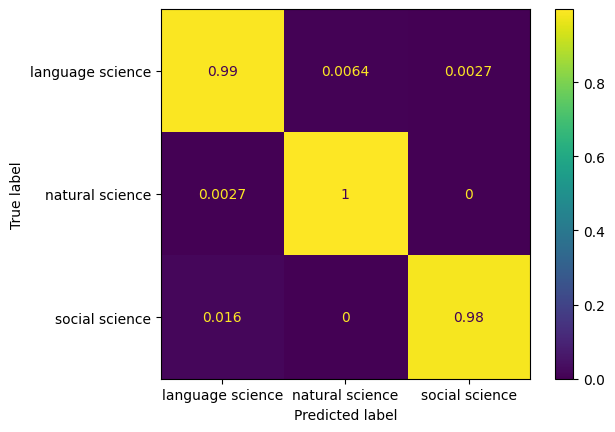

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = tf.argmax(model.predict(test_dataset), axis=1)
y_test_max = tf.argmax(y_test, axis=1)


cmd = ConfusionMatrixDisplay(confusion_matrix(y_test_max, y_pred, normalize='true'), display_labels=labels)
cmd.plot()

# Let's predict Topic now!

In [33]:
selected_label = "topic"
not_selected_label = "subject"
# drop not selected label
ds_LSTM = ds_LSTM.map(
    lambda x: x,
    batched=True,
    remove_columns=[not_selected_label] if not_selected_label in ds_LSTM["train"].features else []
)
# Separate features from label
X = ds_LSTM.map(
    lambda x: x,
    batched=True,
    remove_columns=[selected_label] if selected_label in ds_LSTM["train"].features else []
)
print(X)
y_train, y_validation, y_test = ds_cleaned["train"][selected_label], ds_cleaned["validation"][selected_label], ds_cleaned["test"][selected_label]


Map:   0%|          | 0/12726 [00:00<?, ? examples/s]

Map:   0%|          | 0/4241 [00:00<?, ? examples/s]

Map:   0%|          | 0/4241 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'choices'],
        num_rows: 12726
    })
    validation: Dataset({
        features: ['question', 'choices'],
        num_rows: 4241
    })
    test: Dataset({
        features: ['question', 'choices'],
        num_rows: 4241
    })
})


### One Hot Encoding

In [34]:
from sklearn.preprocessing import LabelBinarizer

# Crea e addestra l'encoder su tutte le etichette disponibili
encoder = LabelBinarizer()
encoder.fit(y_train + y_validation + y_test)  # tutte insieme per coerenza

# Salviamo la lista di labels
labels = encoder.classes_
print(labels)

# Trasforma le label in vettori one-hot
y_train = encoder.transform(y_train)
y_val   = encoder.transform(y_validation)
y_test  = encoder.transform(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

['biology' 'capitalization' 'chemistry' 'civics' 'culture' 'earth-science'
 'economics' 'figurative-language' 'geography' 'global-studies' 'grammar'
 'literacy-in-science' 'phonological-awareness' 'physics' 'pronouns'
 'punctuation' 'reading-comprehension' 'reference-skills'
 'science-and-engineering-practices' 'units-and-measurement' 'us-history'
 'verbs' 'vocabulary' 'word-study' 'world-history' 'writing-strategies']
(12726, 26)
(4241, 26)
(4241, 26)


### Use TF dataset

In [35]:
# creo dataset tensorflow
train_tf = tf.data.Dataset.from_tensor_slices((train_x, y_train))
valid_tf = tf.data.Dataset.from_tensor_slices((valid_x, y_val))
test_tf = tf.data.Dataset.from_tensor_slices((test_x, y_test))

In [36]:
train_dataset = train_tf.shuffle(buffer_size=10000).batch(batch_size=64).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_tf.batch(batch_size=64).prefetch(tf.data.AUTOTUNE)
test_dataset = test_tf.batch(batch_size=64).prefetch(tf.data.AUTOTUNE)

In [37]:
for batch in train_dataset.take(1):
  print(batch)

(<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b'which statement is supported by the map the silk road connected only asia and europe the silk road allowed merchants to travel from asia to the americas the silk road included both land and sea routes',
       b'what does the idiom in this text suggest speak of the devil joy declared when kenneth strolled into the room joy didn trust kenneth joy had just been speaking about kenneth',
       b'what information supports the conclusion that jennifer inherited this trait jennifer and her mother both wear their hair in braids jennifer parents have red hair they passed down this trait to jennifer',
       b'which object has the most thermal energy metal paper clip at temperature of metal paper clip at temperature of metal paper clip at temperature of',
       b'what information supports the conclusion that wendy acquired this trait wendy likes to look at butterflies and beetles wendy learned to identify insects by reading many books abo

## Let's define a simple LSTM.
### It should be enough, because the three subject classification is an easy task even just given the vocabulary. LSTM can also leverage word order.

### This time we use F1 score metric to evaluate unbalanced classes

In [50]:
NUM_CLASSES = y_train.shape[1]
print("num classes = ", NUM_CLASSES)

from tensorflow.keras import Sequential
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorizer,
    tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()), output_dim=64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

f1 = tf.keras.metrics.F1Score(
    average="macro", threshold=None, name='f1_score', dtype=None
)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy', f1], optimizer=tf.keras.optimizers.Adam(1e-4))


num classes =  26


In [51]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, None, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,994 (1.51 MB)

 Trainable params: 395,994 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

model.fit(
    train_dataset,
    epochs=100,
    validation_data=valid_dataset,
    validation_steps=20,
    callbacks=[EarlyStopping(monitor='val_f1_score', mode='max', patience=10, restore_best_weights=True)])

Epoch 1/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.0361 - f1_score: 0.0066 - loss: 0.5956 - val_accuracy: 0.2008 - val_f1_score: 0.0129 - val_loss: 0.1570
Epoch 2/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.1925 - f1_score: 0.0125 - loss: 0.1479 - val_accuracy: 0.1914 - val_f1_score: 0.0125 - val_loss: 0.1363
Epoch 3/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.1849 - f1_score: 0.0162 - loss: 0.1361 - val_accuracy: 0.2508 - val_f1_score: 0.0322 - val_loss: 0.1320
Epoch 4/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.2733 - f1_score: 0.0406 - loss: 0.1314 - val_accuracy: 0.3148 - val_f1_score: 0.0508 - val_loss: 0.1277
Epoch 5/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.2989 - f1_score: 0.0502 - loss: 0.1262 - val_accuracy: 0.3680 - val_f1_score: 0.0675 - val_loss: 0.1214
Epoch 6/100
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.3741 - f1_score: 0.0689 - loss: 0.1193 - val_accuracy: 0.4305 - val_f1_s

In [55]:
valid_loss, valid_acc, valid_f1 = model.evaluate(valid_dataset)
test_loss, test_acc, test_f1 = model.evaluate(test_dataset)

print('Validation Loss: {}'.format(valid_loss))
print('Validation Accuracy: ',valid_acc)
print('Validation F1 Score: ',valid_f1)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: ',test_acc)
print('Test F1 Score: ',test_f1)

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9569 - f1_score: 0.6735 - loss: 0.0128
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9580 - f1_score: 0.6939 - loss: 0.0119
Validation Loss: 0.012222209945321083
Validation Accuracy:  0.9596793055534363
Validation F1 Score:  0.6826584339141846
Test Loss: 0.011445700190961361
Test Accuracy:  0.9608582854270935
Test F1 Score:  0.6935889720916748


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
(4241, 26)
26


<Figure size 1500x1500 with 0 Axes>

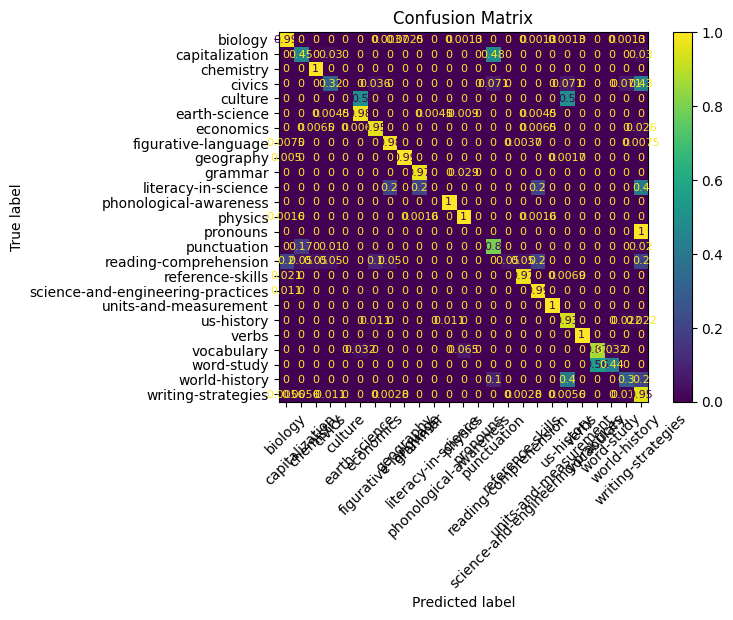

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(test_dataset)
print(y_pred.shape)
print(len(labels))
y_pred = tf.argmax(y_pred, axis=1)
y_test_max = tf.argmax(y_test, axis=1)


# G# Get the unique labels from the predictions and the actual labels
unique_labels = np.unique(np.concatenate([y_pred.numpy(), y_test_max.numpy()]))

# Filter the original labels to include only the unique labels
display_labels = [labels[i] for i in unique_labels]

# Create the ConfusionMatrixDisplay
cmd = ConfusionMatrixDisplay(
    confusion_matrix(y_test_max, y_pred, normalize="true"),
    display_labels=display_labels,
)

# Increase figure size, rotate x-axis labels, and reduce font size
plt.figure(figsize=(15, 15))  # Adjust figure size as needed
cmd.plot(
    include_values=True,
    cmap="viridis",  # Choose a suitable colormap
    xticks_rotation=45,
    text_kw={"fontsize": 8},  # Adjust font size as needed
)
plt.title("Confusion Matrix")
plt.show()